# Robotic control based on hand gestures
### Aprendizaje Automático para la Robótica
### Máster Universitario en Ingeniería Industrial

## Objectives

- Implement an almost complete workflow of deep neural networks in robotic control.
- Apply deep learning to problems with few data using transfer learning and data augmentation.
- Interpret the training of a neural network with TensorBoard.
- Understand the role of fine-tuning a neural network.

## Introduction

A common problem in many robotic systems is enabling a mechanism for a human operator to give commands to a robot. In the world of software, there is a similar problem called HMI (*Human-Machine Interaction*), which goes beyond traditional user interface design. In the world of Robotics, HMI has an equivalent called HRI (*Human-Robot Interaction*).

Many solutions have been proposed for HRI, ranging from the traditional keyboard to voice interfaces. NASA's JPL, for example, proposed the [BioSleeve](https://www.semanticscholar.org/paper/JPL-BioSleeve-for-gesture-based-control%3A-Technology-Assad-Wolf/18152a964e128e247a706dc8729036369b536b48), a gesture recognition system based on electromyography used for robotic control.

In this practice, we will implement an HRI system using gesture recognition with Computer Vision. To do this, we will start with a dataset distributed with TensorFlow, which was intended to implement a video game based on the traditional rock-paper-scissors game. This dataset contains synthetic images of hands making the three gestures.

The objective of this practice is to create a neural network capable of recognizing the gesture based on a photograph, and once identified, sending the corresponding command to the deliberative layer of the robotic controller (part that will not be implemented in this practice, but which would be relatively easy with the image recognition implemented). Since the dataset allows us to recognize three gestures, we can create an interface with three commands, for example, "stop", "go forward", and "go back". These symbols could be combined to build a broader language, but that is outside the scope of this assignment.

The objective is, therefore, to implement image classification with three different classes, for which we will use different strategies, from basic network training, through data augmentation, knowledge transfer, and fine-tuning of the model.

The implementation of the practice is complete, and the questions asked at the end of each section must be answered, which in some cases involves reusing code. Please be careful not to overwrite variables to avoid problems with the notebook.

The dataset for this practice was created by [Laurence Moroney](https://laurencemoroney.com/datasets.html). The practice contains code from [various](https://colab.research.google.com/github/trekhleb/machine-learning-experiments/blob/master/experiments/rock_paper_scissors_cnn/rock_paper_scissors_cnn.ipynb#scrollTo=kpRWiLQy-sd5) [sources](https://github.com/lmoroney/io19/blob/master/Zero%20to%20Hero/Rock-Paper-Scissors.ipynb).


## Prerrequisites

A GPU is needed to develop this assignment, otherwise the computation times will make it difficult to complete. Since having a GPU and, above all, its proper configuration is problematic, the assignment is designed to be run from **Google Colab**, which does not require any additional hardware, as well as locally in a **Linux-based computer with GPU**.

Additionally, there is an optional part of the practice to integrate the neural model with a **webcam**, simulating the camera on the robot. As before, this optional part of the practice is prepared to be run locally or from Google Colab.
 
## Imports and definitions

In [ ]:
!pip install keras-preprocessing

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf

import keras_preprocessing

from tensorflow import keras

import os
import datetime

2023-03-15 09:37:17.729899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 09:37:17.770911: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 64

TRAINING_DIR = "rps/"
VALIDATION_DIR = "rps-test-set/"

In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Uncomment to disable GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-03-15 09:37:21.374437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 09:37:21.390735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 09:37:21.390877: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Validation set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Validation set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

Prepare TensorBoard.

In [5]:
os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/'

In [6]:
# Clear any logs from previous runs.
#!rm -rf ./logs/

## Downloading the dataset

In [7]:
!wget -O rps.zip https://universidaddealcala-my.sharepoint.com/:u:/g/personal/david_fernandezb_uah_es/EXuHkhJysEdAp_ADxSkTj-wBUFFZkSygi-4ziuQ6o_SxdQ?download=1
!echo
!wget -O rps-test-set.zip https://universidaddealcala-my.sharepoint.com/:u:/g/personal/david_fernandezb_uah_es/Eekb7bLpPYpCkzKdmwVprssBVnRBT0ZPqi-4_OMD_vtXCA?download=1            

--2023-03-15 09:37:42--  https://universidaddealcala-my.sharepoint.com/:u:/g/personal/david_fernandezb_uah_es/EXuHkhJysEdAp_ADxSkTj-wBUFFZkSygi-4ziuQ6o_SxdQ?download=1
Resolving universidaddealcala-my.sharepoint.com (universidaddealcala-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to universidaddealcala-my.sharepoint.com (universidaddealcala-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/david_fernandezb_uah_es/Documents/Documentos/datos/rps.zip?ga=1 [following]
--2023-03-15 09:37:42--  https://universidaddealcala-my.sharepoint.com/personal/david_fernandezb_uah_es/Documents/Documentos/datos/rps.zip?ga=1
Reusing existing connection to universidaddealcala-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 200884156 (192M) [application/x-zip-compressed]
Saving to: ‘rps.zip’

rps.zip             100%[===================>] 191,58M  37,3MB/s    in 5,1s    

In [8]:
# Delete the dataset. Caution with this!
#!rm -rf rps/
#!rm -rf rps-test-set/

In [9]:
!unzip rps.zip > /dev/null
!unzip rps-test-set.zip > /dev/null

In [10]:
!ls

gesture.ipynb  model.png  rps  rps-test-set  rps-test-set.zip  rps.zip


In [11]:
!ls rps

paper  rock  scissors


In [12]:
!ls rps/paper | head

paper01-000.png
paper01-001.png
paper01-002.png
paper01-003.png
paper01-004.png
paper01-005.png
paper01-006.png
paper01-007.png
paper01-008.png
paper01-009.png


## Inspecting data

In [13]:
rock_dir = os.path.join('rps/rock')
paper_dir = os.path.join('rps/paper')
scissors_dir = os.path.join('rps/scissors')

print('Total training rock images:', len(os.listdir(rock_dir)))
print('Total training paper images:', len(os.listdir(paper_dir)))
print('Total training scissors images:', len(os.listdir(scissors_dir)))
print()

rock_files = os.listdir(rock_dir)
print(rock_files[:3])

paper_files = os.listdir(paper_dir)
print(paper_files[:3])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:3])

Total training rock images: 840
Total training paper images: 840
Total training scissors images: 840

['rock02-000.png', 'rock06ck02-024.png', 'rock06ck02-099.png']
['paper06-077.png', 'paper01-042.png', 'paper07-112.png']
['scissors04-032.png', 'scissors03-059.png', 'testscissors02-061.png']


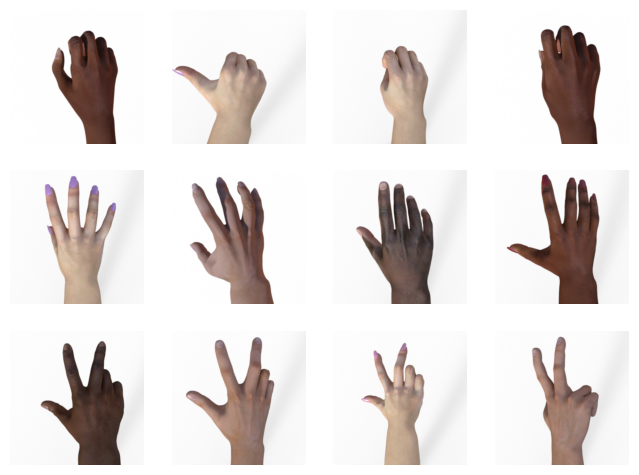

In [14]:
pic_index = 4

next_rock = [os.path.join(rock_dir, fname) for fname in rock_files[pic_index-4:pic_index]]
next_paper = [os.path.join(paper_dir, fname) for fname in paper_files[pic_index-4:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) for fname in scissors_files[pic_index-4:pic_index]]

plt.figure(figsize=(8, 8))
for i, img_path in enumerate(next_rock+next_paper+next_scissors):
    #print(img_path)
    img = Image.open(img_path)
    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.axis('Off')

plt.show()

## Build our dataset

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAINING_DIR,
  color_mode="rgb",
  label_mode='categorical',
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VALIDATION_DIR,
    label_mode='categorical',
    color_mode="rgb",
    image_size=IMAGE_SIZE,
    batch_size=1
)

Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


2023-03-15 09:38:24.683867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 09:38:24.684327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 09:38:24.684477: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 09:38:24.684561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node,

Double check if our data is normalized.

In [16]:
for images, labels in train_ds.take(1):  # only take first batch of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    
print("Labels: ")
print(numpy_labels[0])
print("")

print("Example of one channel in one image from the batch")
print(numpy_images[0,:,:,0])

print()
print(f"Max: {np.max(numpy_images)}")
print(f"Min: {np.min(numpy_images)}")

del numpy_images
del numpy_labels

Labels: 
[0. 1. 0.]

Example of one channel in one image from the batch
[[253.5  253.25 253.25 ... 239.   239.   239.75]
 [253.5  253.25 253.25 ... 239.   238.75 239.  ]
 [253.5  253.25 253.   ... 238.5  239.   240.75]
 ...
 [251.75 251.75 250.75 ... 248.5  248.5  248.75]
 [252.25 252.   251.75 ... 248.5  249.25 249.  ]
 [252.   252.   251.5  ... 248.5  248.5  248.5 ]]

Max: 255.0
Min: 6.5


Please observe that the dataset is not normalized.

## Exercises

1. How does the function *image_dataset_from_directory()* know the class to which a file belongs? Check out the contents of the dataset in case you need to. You have a direct link to the dataset [here](https://universidaddealcala-my.sharepoint.com/:u:/g/personal/david_fernandezb_uah_es/EXuHkhJysEdAp_ADxSkTj-wBUFFZkSygi-4ziuQ6o_SxdQ?download=1).

2. Does the function *image_dataset_from_directory()* implement any preprocess?

## Model definition

In [17]:
def create_cnn_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='softmax')
        ])

In [18]:
cnn = create_cnn_model()

In [19]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       7

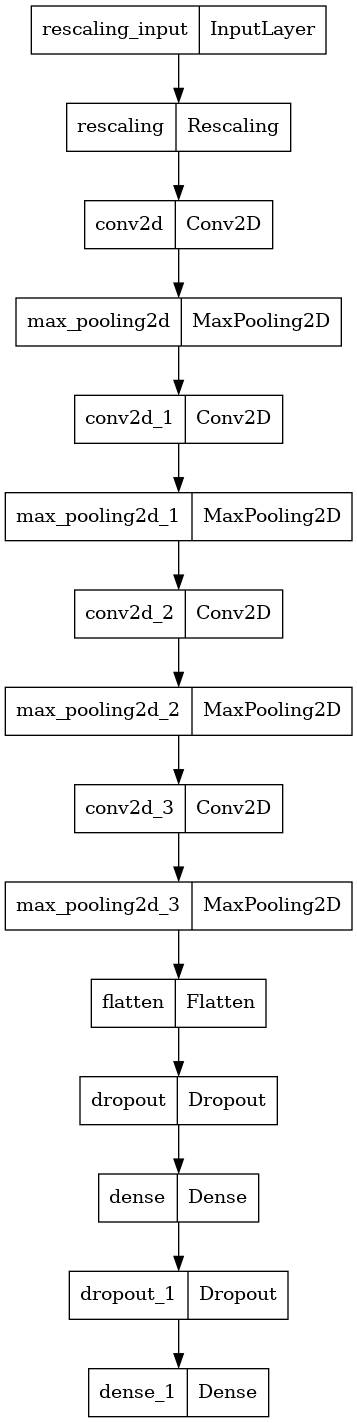

In [20]:
from keras.utils.vis_utils import plot_model

plot_model(cnn)

## Exercises

1. What is the function implemented by *tf.keras.layers.Rescaling* and what is the role of the *input_shape* argument?

2. Notice that the number of filters in the convolutional layers increases as the network gets deeper, what is the purpose, if any, of designing the network in this way?

3. What is the function of the *tf.keras.layers.Flatten* layer?

4. Observe the distribution of the number of parameters per layer, where are there more parameters?

## Training the basic model

Please keep in mind that the fit() method has memory, which implies that its internal state is not reset when called.

In [21]:
cnn.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

The following call to *fit()* contains a callback to TensorBoard; it only saves a log of the network in the directory specified by *log_dir*. The log can be viewed later using TensorBoard, which we will do at a later stage. The cell also contains the magic '%%time', which shows the cell execution time, it is used later.

In [22]:
%%time

history = cnn.fit(train_ds.prefetch(tf.data.AUTOTUNE), epochs=15, validation_data = validation_ds.prefetch(tf.data.AUTOTUNE),
    callbacks=
        [tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_log_dir + "cnn-" + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'),
        histogram_freq=1
        )]);

Epoch 1/15


2023-03-15 09:38:47.124717: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-03-15 09:38:48.099025: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


40/40 [==============================] - 5s 64ms/step - loss: 0.7745 - accuracy: 0.6048 - val_loss: 0.4298 - val_accuracy: 0.8253
Epoch 2/15
40/40 [==============================] - 2s 46ms/step - loss: 0.1514 - accuracy: 0.9540 - val_loss: 0.1732 - val_accuracy: 0.9543
Epoch 3/15
40/40 [==============================] - 2s 46ms/step - loss: 0.0647 - accuracy: 0.9774 - val_loss: 0.1217 - val_accuracy: 0.9597
Epoch 4/15
40/40 [==============================] - 2s 48ms/step - loss: 0.0269 - accuracy: 0.9901 - val_loss: 0.1093 - val_accuracy: 0.9516
Epoch 5/15
40/40 [==============================] - 2s 47ms/step - loss: 0.0199 - accuracy: 0.9917 - val_loss: 0.2758 - val_accuracy: 0.8925
Epoch 6/15
40/40 [==============================] - 2s 47ms/step - loss: 0.0113 - accuracy: 0.9968 - val_loss: 0.2052 - val_accuracy: 0.9247
Epoch 7/15
40/40 [==============================] - 2s 47ms/step - loss: 0.0065 - accuracy: 0.9976 - val_loss: 0.0884 - val_accuracy: 0.9785
Epoch 8/15
40/40 [======

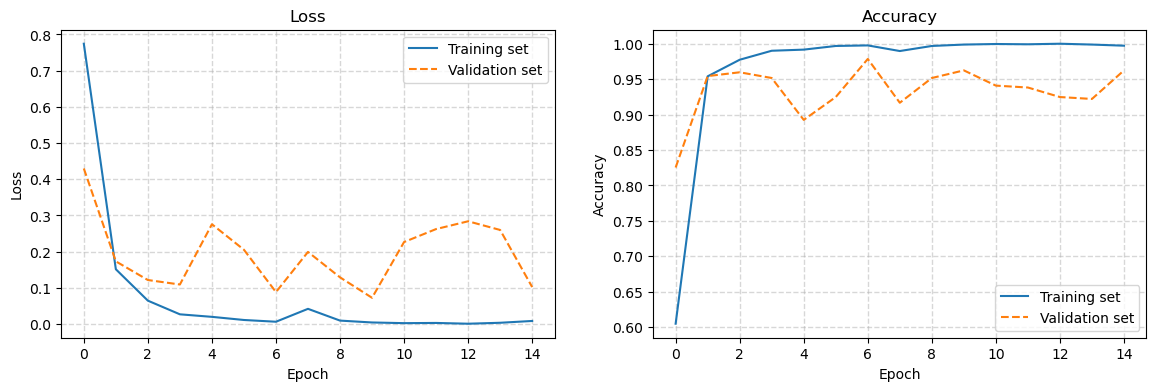

In [23]:
plot_history(history)

## Excercises

1. Measure the training computation time with and without GPU. You may need to restart the notebook.

2. Look at the loss and accuracy graph. Is the network learning properly?

3. If you have noticed any issues in the training process, propose potential solutions to address them.

4. Reduce significantly the size of the network and interpret the training metrics. Save the result in the *cnn_mini* and *history_mini* variables to avoid affecting other parts of the notebook's code. Be careful when changing the name of the logs saved for TensorBoard, as it may complicate other parts of the exercise.

In [ ]:
cnn_mini = None
history_mini = None

# YOUR CODE HERE

ANALIZE YOUR RESULTS HERE

## Using data augmentation

It is very common for a neural network to be comparatively large in size with respect to the amount of available data. In these cases, it may be advisable to reduce the size of the network, introduce regularization, or artificially increase the amount of available data by adding random variations to the existing data, known as "data augmentation." Implementing this with Keras is really simple.

In [24]:
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(
#      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator()
#validation_datagen = ImageDataGenerator(rescale = 1./255)


train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=IMAGE_SIZE,
	class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=IMAGE_SIZE,
	class_mode='categorical'
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


Let's visualize our augmented data to check if everything is working as it should. Please note that we do not modify the validation dataset, although it is not necessary to keep it this way.

Training data augmentation

Plotting rps/rock/rock02-000.png


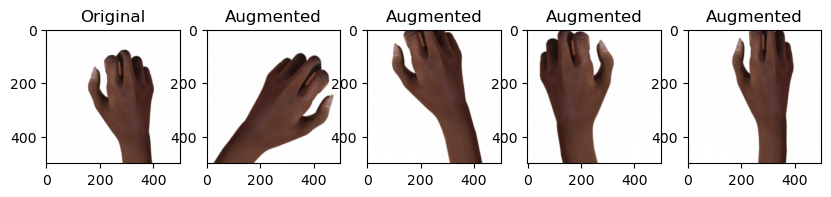

Plotting rps/rock/rock06ck02-024.png


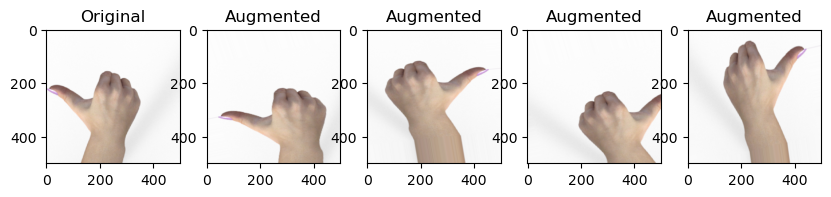

Validation data augmentation

Plotting rps/rock/rock06ck02-024.png


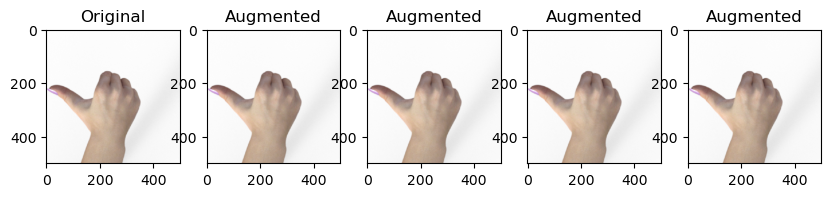

In [25]:
def plot_augmented(image, generator):
    print(f"Plotting {image}")
    
    img = keras.preprocessing.image.load_img(image, target_size= (500,500))
    img_tensor = keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)#Uses ImageDataGenerator to flip the images
    #datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

    plt.figure(figsize=(10, 14))
    plt.subplot(1, 5, 1)
    plt.imshow(img) # Original image
    plt.title("Original")

    #pic = datagen.flow(img_tensor, batch_size =1)
    pic = generator.flow(img_tensor, batch_size=1)

    for i in range(2, 6):
      plt.subplot(1, 5, i)
      batch = pic.next()
      image_ = batch[0].astype('uint8')
      plt.imshow(image_)
      plt.title("Augmented")    
    plt.show()

print("Training data augmentation\n")
plot_augmented(next_rock[0], training_datagen)
plot_augmented(next_rock[1], training_datagen)

print("Validation data augmentation\n")
plot_augmented(next_rock[1], validation_datagen)

In [26]:
cnn_aug = create_cnn_model()

In [27]:
cnn_aug.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
history = cnn_aug.fit(train_generator, epochs=15, validation_data = validation_generator, 
    callbacks=
        [tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_log_dir + "aug-cnn-" + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'),
        histogram_freq=1
        )]);

Epoch 1/15
79/79 [==============================] - 10s 110ms/step - loss: 1.1030 - accuracy: 0.3357 - val_loss: 1.0985 - val_accuracy: 0.3333
Epoch 2/15
79/79 [==============================] - 9s 107ms/step - loss: 1.0801 - accuracy: 0.3980 - val_loss: 1.0237 - val_accuracy: 0.6720
Epoch 3/15
79/79 [==============================] - 8s 107ms/step - loss: 0.8868 - accuracy: 0.5778 - val_loss: 0.4356 - val_accuracy: 0.8737
Epoch 4/15
79/79 [==============================] - 9s 109ms/step - loss: 0.6339 - accuracy: 0.7222 - val_loss: 0.1969 - val_accuracy: 1.0000
Epoch 5/15
79/79 [==============================] - 9s 109ms/step - loss: 0.5217 - accuracy: 0.7782 - val_loss: 0.1951 - val_accuracy: 0.9785
Epoch 6/15
79/79 [==============================] - 9s 108ms/step - loss: 0.4080 - accuracy: 0.8401 - val_loss: 0.1383 - val_accuracy: 0.9624
Epoch 7/15
79/79 [==============================] - 9s 108ms/step - loss: 0.3457 - accuracy: 0.8750 - val_loss: 0.0563 - val_accuracy: 1.0000
Epoch

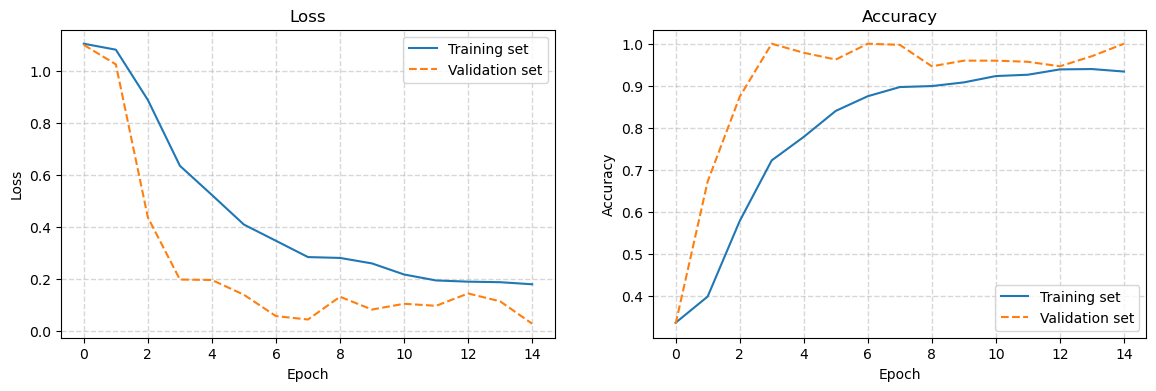

In [29]:
plot_history(history)

## Exercises

1. What transformations are we applying to the train and validation dataset?

2. Explain the utility of the class *ImageDataGenerator*.

3. Compare the loss and accuracy of the model trained with augmented data to the first training without augmented data. Is there any difference noticed? Justify the answer in detail.

4. Observe that validation loss and accuracy are better than those in training, is that something expected?

## Debug the network with TensorBoard

In [ ]:
# Load the TensorBoard notebook extension.
# %reload_ext tensorboard
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/fit

## Exercises

1. Compare the value of loss in validation over time using data augmentation and not using it, visualizing it with TensorBoard. Does data augmentation improve the model generalization?

2. Do the same than the previous cell using accuracy as metric.

3. Visualize the evolution of weights and biases over time.

4. Could you apply the preceding visualization to identify any issues during the training process?

## Transfer learning (optional)

In [30]:
from keras.applications.vgg16 import VGG16

vgg = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
vgg.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [31]:
from keras.layers import Dense, Dropout, Flatten

wrapper_vgg = keras.models.Sequential([
#    tf.keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    vgg,
    Flatten(),
    Dropout(0.5),
    Dense(25, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

wrapper_vgg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_4 (Dropout)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 25)                204825    
                                                                 
 dropout_5 (Dropout)         (None, 25)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 78        
                                                                 
Total params: 14,919,591
Trainable params: 204,903
Non

In [32]:
wrapper_vgg.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
from keras.applications.vgg16 import preprocess_input


vgg_training_datagen = ImageDataGenerator(
#      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2, # Cuidado
      preprocessing_function=preprocess_input # Look this line
)

#vgg_validation_datagen = ImageDataGenerator() 
vgg_validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # Look this line
#validation_datagen = ImageDataGenerator(rescale = 1./255)


vgg_train_generator = vgg_training_datagen.flow_from_directory(
	TRAINING_DIR,
    subset="training", # Cuidado
	target_size=(150, 150),
	class_mode='categorical'
)

vgg_validation_generator = vgg_validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150, 150),
	class_mode='categorical'
)

Found 2016 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [34]:
history = wrapper_vgg.fit(vgg_train_generator, epochs=15, validation_data=vgg_validation_generator, 
    callbacks=
        [tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_log_dir + "vgg16" + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'),
        histogram_freq=1
        )]);

Epoch 1/15
63/63 [==============================] - 9s 129ms/step - loss: 1.7356 - accuracy: 0.6667 - val_loss: 0.3849 - val_accuracy: 0.9516
Epoch 2/15
63/63 [==============================] - 7s 118ms/step - loss: 0.5329 - accuracy: 0.8145 - val_loss: 0.2256 - val_accuracy: 0.8925
Epoch 3/15
63/63 [==============================] - 7s 118ms/step - loss: 0.4237 - accuracy: 0.8611 - val_loss: 0.1963 - val_accuracy: 0.9355
Epoch 4/15
63/63 [==============================] - 7s 118ms/step - loss: 0.3534 - accuracy: 0.8790 - val_loss: 0.2637 - val_accuracy: 0.9167
Epoch 5/15
63/63 [==============================] - 8s 119ms/step - loss: 0.3233 - accuracy: 0.8998 - val_loss: 0.2952 - val_accuracy: 0.8844
Epoch 6/15
63/63 [==============================] - 7s 119ms/step - loss: 0.2853 - accuracy: 0.9048 - val_loss: 0.3861 - val_accuracy: 0.8522
Epoch 7/15
63/63 [==============================] - 8s 119ms/step - loss: 0.2922 - accuracy: 0.9077 - val_loss: 0.4426 - val_accuracy: 0.8952
Epoch 

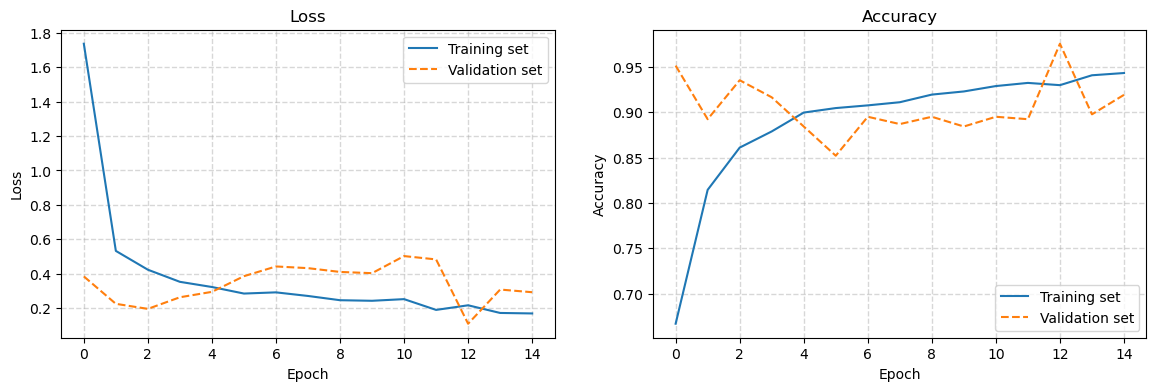

In [35]:
plot_history(history)

## Questions

1. What is the purpose of the *weights* argument during model instantiation?

2. What is the purpose of setting the *include_top* parameter to false during model instantiation?

3. Which is the difference between the models *vgg* and *wrapper_vgg*?

4. When requesting a summary of a model, Keras distinguishes between trainable and non-trainable parameters. What is the reason for this distinction? For instance, the summary of the *wrapper_vgg* model yields the following.

~~~Bash
Total params: 14,919,591
Trainable params: 204,903
Non-trainable params: 14,714,688
~~~

5. Observe that the last layer of the wrapper_vgg model contains only 25 neurons, in contrast to the previous models which have twice as many, 50. What is the reason for this difference in the network design?

## Fine-tuning of the VGG16 model (optional)

In [36]:
for layer in wrapper_vgg.layers:
    layer.trainable = True
    
wrapper_vgg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_4 (Dropout)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 25)                204825    
                                                                 
 dropout_5 (Dropout)         (None, 25)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 78        
                                                                 
Total params: 14,919,591
Trainable params: 14,919,591


In [37]:
optimizer = keras.optimizers.legacy.SGD(learning_rate=1e-5, momentum=0.9, decay=0.0001)

wrapper_vgg.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [38]:
history = wrapper_vgg.fit(vgg_train_generator, epochs=10, validation_data=vgg_validation_generator, 
    callbacks=
        [tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_log_dir + "vgg16-fine-" + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'),
        histogram_freq=1
        )]);

Epoch 1/10
63/63 [==============================] - 11s 122ms/step - loss: 0.1655 - accuracy: 0.9494 - val_loss: 0.1203 - val_accuracy: 0.9651
Epoch 2/10
63/63 [==============================] - 8s 120ms/step - loss: 0.1626 - accuracy: 0.9549 - val_loss: 0.1415 - val_accuracy: 0.9516
Epoch 3/10
63/63 [==============================] - 8s 120ms/step - loss: 0.1519 - accuracy: 0.9504 - val_loss: 0.0886 - val_accuracy: 0.9919
Epoch 4/10
63/63 [==============================] - 8s 119ms/step - loss: 0.1132 - accuracy: 0.9628 - val_loss: 0.2334 - val_accuracy: 0.9167
Epoch 5/10
63/63 [==============================] - 8s 119ms/step - loss: 0.1100 - accuracy: 0.9633 - val_loss: 0.2424 - val_accuracy: 0.9167
Epoch 6/10
63/63 [==============================] - 8s 118ms/step - loss: 0.1121 - accuracy: 0.9648 - val_loss: 0.1111 - val_accuracy: 0.9489
Epoch 7/10
63/63 [==============================] - 8s 119ms/step - loss: 0.1003 - accuracy: 0.9722 - val_loss: 0.1046 - val_accuracy: 0.9543
Epoch

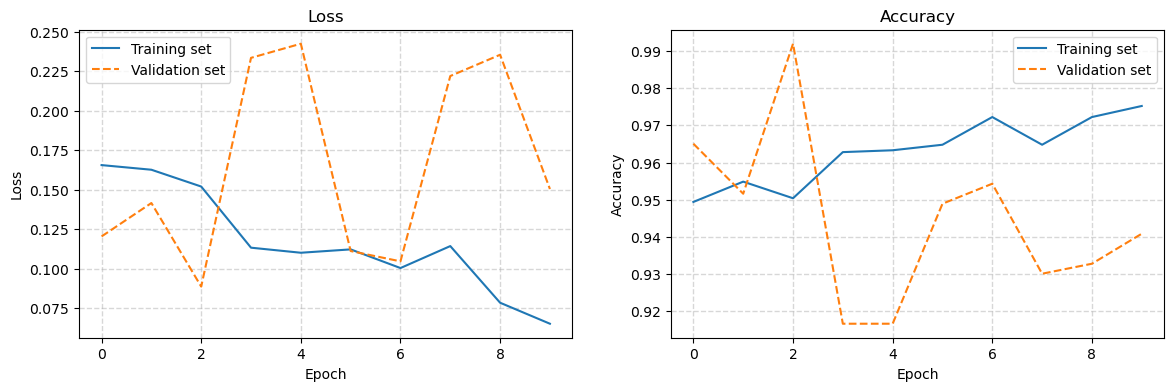

In [39]:
plot_history(history)

## Questions

0. Which is the purpose of fine-tuning a model?

1. Observe which layers are trainable, the optimizer and the learning rate applied, ¿why is the learning rate so low?

2. Which is the function of the *decay* parameter in the optimizer instantiation?

3. Looking at the loss and accuracy, has fine-tuninig improved our previous model?

4. Would fine-tuning benefit from additional training? If you think so, try to train the model a few epochs more.

In [ ]:
# YOUR CODE HERE

## Tranfer learning with another architecture (optional)

Train a model using an alternative architecture, trained, or not, with Imagenet or any other Computer Vision dataset.

In [ ]:
# YOUR CODE HERE

## Predict on new images (just for fun)

In [40]:
def predict_image(model, image):
    plt.imshow(img)
    plt.show()

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array, verbose=0)

    print("\nClass probabilities:")
    for label, index in vgg_train_generator.class_indices.items():
        print(f"\t-{label}: {predictions[0][index]}")

    y_classes = predictions.argmax(axis=-1)
    print("Gesture label: " + list(vgg_train_generator.class_indices.keys())[y_classes[0]])
    
#labels = (train_generator.class_indices)
#labels = dict((v,k) for k,v in labels.items())
#predictions = [labels[k] for k in predicted_class_indices]

### Open a file in a local file system

In [41]:
!ls rps-test-set/paper

testpaper01-00.png  testpaper02-00.png	testpaper03-00.png  testpaper04-00.png
testpaper01-01.png  testpaper02-01.png	testpaper03-01.png  testpaper04-01.png
testpaper01-02.png  testpaper02-02.png	testpaper03-02.png  testpaper04-02.png
testpaper01-03.png  testpaper02-03.png	testpaper03-03.png  testpaper04-03.png
testpaper01-04.png  testpaper02-04.png	testpaper03-04.png  testpaper04-04.png
testpaper01-05.png  testpaper02-05.png	testpaper03-05.png  testpaper04-05.png
testpaper01-06.png  testpaper02-06.png	testpaper03-06.png  testpaper04-06.png
testpaper01-07.png  testpaper02-07.png	testpaper03-07.png  testpaper04-07.png
testpaper01-08.png  testpaper02-08.png	testpaper03-08.png  testpaper04-08.png
testpaper01-09.png  testpaper02-09.png	testpaper03-09.png  testpaper04-09.png
testpaper01-10.png  testpaper02-10.png	testpaper03-10.png  testpaper04-10.png
testpaper01-11.png  testpaper02-11.png	testpaper03-11.png  testpaper04-11.png
testpaper01-12.png  testpaper02-12.png	testpaper03-12.png  testp

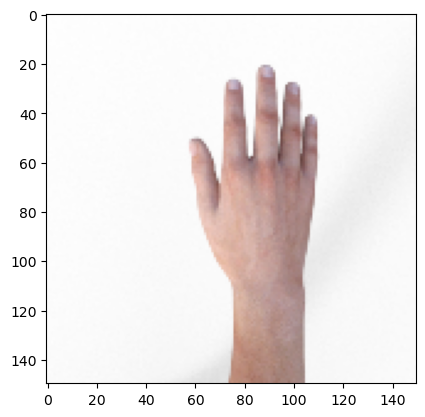


Class probabilities:
	-paper: 1.0
	-rock: 5.020503327304859e-13
	-scissors: 1.1179447589881875e-08
Gesture label: paper


In [42]:
img = keras.preprocessing.image.load_img("rps-test-set/paper/testpaper03-30.png", target_size=IMAGE_SIZE)

predict_image(wrapper_vgg, img)

### Image with a webcam (Jupyter version)

In [ ]:
!conda install -c conda-forge opencv

In [ ]:
import cv2

def take_picture():
    cam = cv2.VideoCapture(0)

    cv2.namedWindow("MUII - AAR")

    img_counter = 0

    print("Press <SPACE> to take a snapshot, press <ESC> to quit.")

    while True:
        ret, frame = cam.read()
        if not ret:
            print("failed to grab frame")
            break
        cv2.imshow("test", frame)

        k = cv2.waitKey(1)
        if k%256 == 27:
            # ESC pressed
            print("Escape hit, closing...")
            break
        elif k%256 == 32:
            # SPACE pressed
            img_name = "capture_{}.png".format(img_counter)
            cv2.imwrite(img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1

    cam.release()

    cv2.destroyAllWindows()

In [ ]:
take_picture()

img = keras.preprocessing.image.load_img("capture_0.png", target_size=IMAGE_SIZE)

predict_image(wrapper_vgg, img)

### Upload a local image (Google Colab)

In [ ]:
try:
    import google.colab
    uploaded = files.upload()

except:
    print("Not in Google Colab")

In [ ]:
try:
    import google.colab

    for filename in uploaded.keys():
    img = keras.preprocessing.image.load_img(filename, target_size=IMAGE_SIZE)

    predict_image(wrapper_vgg, img)
    
except:
    print("Not in Google Colab")

### Take a picture with a webcam (Google Colab)

In [ ]:
try:
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    def take_photo(filename='photo.jpg', quality=0.8):
      js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);
    
          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});
    
          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize the output to fit the video element.
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          // Wait for Capture to be clicked.
          await new Promise((resolve) => capture.onclick = resolve);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
      display(js)
      data = eval_js('takePhoto({})'.format(quality))
      binary = b64decode(data.split(',')[1])
      with open(filename, 'wb') as f:
        f.write(binary)
      return filename

except:
    print("Not in Google Colab")

In [ ]:
from IPython.display import Image

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))

except Exception as err:
  print(str(err))

In [ ]:
img = keras.preprocessing.image.load_img("photo.jpg", target_size=IMAGE_SIZE)

predict_image(wrapper_vgg, img)